In [1]:
import argparse
import logging
import numpy as np
import pyvista as pv

from pathlib import Path
from pointcept.supplemental.utils import disable_trame_logger
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    process_folds,
    plot_mesh_folds,
    persist_best_iteration,
    load_best_iteration,
    crop_meshes_per_fold,
    save_splits
)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

label = 'rog_south'

set_data_root("../../data")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dh = DataHandler(label)
dh.ensure_meshes()

04:26:26 - INFO - Label rog_south already has extracted meshes.


In [3]:
analyser = MeshAnalyser(data_handler=dh)

In [4]:
to_exclude = []
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

04:26:28 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '12_RWP', '13_OTHER'].
04:26:28 - INFO - Sampling with resolution 0.15.
04:26:29 - INFO - Number of points after initial sampling: 5515655
04:26:31 - INFO - Number of points after Poisson Disk Sampling: 481633
04:26:31 - INFO - Number of points after initial sampling: 696084
04:26:32 - INFO - Number of points after Poisson Disk Sampling: 140256
04:26:32 - INFO - Number of points after initial sampling: 378012
04:26:32 - INFO - Number of points after Poisson Disk Sampling: 44007
04:26:32 - INFO - Number of points after initial sampling: 1553631
04:26:32 - INFO - Number of points after Poisson Disk Sampling: 83679
04:26:32 - INFO - Number of points after initial sampling: 750448
04:26:33 - INFO - Number of points after Poisson Disk Sampling: 145095
04:26:33 - INFO - Number of points after initial sampling: 38353

In [5]:
binning = analyser.evaluate_binning(pcds, x_cell_width=6.0, y_cell_width=6.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

04:26:34 - INFO - Binning is using 8 bins in X and 17 bins in Y based on cell widths of 6.0 and 6.0.


In [36]:
import matplotlib.pyplot as plt

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1 - amount) to the existing RGB values.
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except KeyError:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    lightened_color = colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    return lightened_color


def shift_color_towards_red(color, amount=0.03):
    """
    Shifts the given color slightly towards the red part of the spectrum by adjusting the hue.
    
    Args:
        color: The color to shift (can be a named color or RGB tuple).
        amount: The amount by which to shift the hue towards red (default: 0.1). 
                Positive values shift towards red.
                
    Returns:
        A tuple representing the RGB values of the adjusted color.
    """
    import matplotlib.colors as mc
    import colorsys
    
    try:
        c = mc.cnames[color]
    except KeyError:
        c = color
    
    # Convert to HLS color space
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    
    # Shift hue towards red
    new_hue = (c[0] - amount) % 1  # Ensure hue stays within [0, 1]
    
    # Convert back to RGB
    shifted_color = colorsys.hls_to_rgb(new_hue, c[1], c[2])
    
    return shifted_color

def desaturate_color(color, amount=0.05):
    """
    Desaturates the given color by reducing its saturation.
    
    Args:
        color: The color to desaturate (can be a named color or RGB tuple).
        amount: The amount by which to reduce the saturation (default: 0.5). 
                1.0 means fully desaturated (gray), and 0.0 means no change.
                
    Returns:
        A tuple representing the RGB values of the desaturated color.
    """
    import matplotlib.colors as mc
    import colorsys
    
    try:
        c = mc.cnames[color]
    except KeyError:
        c = color
    
    # Convert to HLS color space
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    
    # Reduce the saturation based on the amount
    new_saturation = c[2] * (1 - amount)  # Scale down the saturation
    
    # Convert back to RGB
    desaturated_color = colorsys.hls_to_rgb(c[0], c[1], new_saturation)
    
    return desaturated_color

In [37]:
import numpy as np
import heapq
import random
from copy import deepcopy
import logging
from itertools import count
import joblib

class Fold:
    def __init__(self, fold_id, weight, region_count, categories):
        self.fold_id = fold_id
        self.weight = weight
        self.region_count = region_count
        self.categories = categories
        self.order_counter = 1  # Initialize per-region order counter

        # Initialize counts
        self.total_counts = 0
        self.category_counts = {cat: 0 for cat in categories}

        # Regions within the fold
        self.regions = []

        # Intended counts and cell counts will be set later
        self.intended_total_counts = 0
        self.intended_cell_counts = 0

    def add_region(self, region):
        self.regions.append(region)
        region.fold = self
        # Compute intended counts for the region
        region.compute_intended_counts()

    def update_counts(self, counts):
        self.total_counts += counts['total']
        for cat in self.categories:
            self.category_counts[cat] += counts[cat]

    def compute_intended_counts(self, total_counts, total_cells):
        self.intended_total_counts = self.weight * total_counts
        self.intended_cell_counts = self.weight * total_cells

class Region:
    def __init__(self, region_id, categories):
        self.region_id = region_id
        self.categories = categories
        self.fold = None  # Will be set when added to a fold

        # Initialize counts
        self.total_counts = 0
        self.category_counts = {cat: 0 for cat in categories}
        self.cell_count = 0  # Number of populated cells in the region

        # Bounding box for compactness calculations
        self.bounding_box = {'min_i': None, 'max_i': None, 'min_j': None, 'max_j': None}

        # Intended counts and cell counts will be set later
        self.intended_total_counts = 0
        self.intended_cell_counts = 0

    def update_counts(self, counts):
        self.total_counts += counts['total']
        self.cell_count += counts['cell']
        for cat in self.categories:
            self.category_counts[cat] += counts[cat]

    def compute_intended_counts(self):
        if self.fold:
            self.intended_total_counts = self.fold.intended_total_counts / self.fold.region_count
            self.intended_cell_counts = self.fold.intended_cell_counts / self.fold.region_count
        else:
            raise ValueError("Region is not associated with a fold.")

In [95]:
from matplotlib.patches import FancyArrowPatch
from skimage import measure
from matplotlib.patches import Rectangle, Polygon
from skimage.measure import approximate_polygon
from skimage.segmentation import find_boundaries
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist

def order_boundary_points(boundary_points):
    # Start with the first point and find the nearest neighbor iteratively
    ordered_points = [boundary_points[0]]
    boundary_points = np.delete(boundary_points, 0, axis=0)
    
    while len(boundary_points) > 0:
        last_point = ordered_points[-1]
        distances = cdist([last_point], boundary_points)
        nearest_idx = np.argmin(distances)
        ordered_points.append(boundary_points[nearest_idx])
        boundary_points = np.delete(boundary_points, nearest_idx, axis=0)
    
    return np.array(ordered_points)

# Helper function to find cell-wise boundaries and scale them based on x_edges and y_edges
def extract_scaled_cell_boundaries(mask, x_edges, y_edges):
    boundaries = []
    rows, cols = mask.shape
    for i in range(rows):
        for j in range(cols):
            if mask[i, j] == 1:  # If the cell is part of the region
                # Top boundary
                if i == 0 or mask[i-1, j] == 0:
                    boundaries.append([[y_edges[i], x_edges[j]], [y_edges[i], x_edges[j+1]]])
                # Bottom boundary
                if i == rows-1 or mask[i+1, j] == 0:
                    boundaries.append([[y_edges[i+1], x_edges[j]], [y_edges[i+1], x_edges[j+1]]])
                # Left boundary
                if j == 0 or mask[i, j-1] == 0:
                    boundaries.append([[y_edges[i], x_edges[j]], [y_edges[i+1], x_edges[j]]])
                # Right boundary
                if j == cols-1 or mask[i, j+1] == 0:
                    boundaries.append([[y_edges[i], x_edges[j+1]], [y_edges[i+1], x_edges[j+1]]])
    return boundaries

class FoldConfiguration:
    def __init__(self, iteration, grid, folds, categories, total_category_counts, total_counts,
                 total_populated_cells, x_edges, y_edges, region_cell_order):
        self.iteration = iteration
        self.grid = grid
        self.folds = folds
        self.categories = categories
        self.total_category_counts = total_category_counts
        self.total_counts = total_counts
        self.total_populated_cells = total_populated_cells
        # self.size_penalty_multiplier = size_penalty_multiplier
        # self.aspect_ratio_penalty_multiplier = aspect_ratio_penalty_multiplier
        self.x_edges = x_edges
        self.y_edges = y_edges
        self.region_cell_order = region_cell_order
        # Compute percentages
        self.compute_category_percentages()

        # Prepare summary data
        self.prepare_summary()

    def compute_category_percentages(self):
        self.fold_percentages = {}
        self.region_percentages = {}

        # Compute fold percentages
        for fold_id, fold in self.folds.items():
            percentages = {}
            for cat in self.categories:
                count = fold.category_counts[cat]
                total_cat_count = self.total_category_counts[cat]
                if total_cat_count > 0:
                    p = count / total_cat_count
                    percentages[cat] = {'percentage': p * 100}
                else:
                    percentages[cat] = {'percentage': 0}
            self.fold_percentages[fold_id] = percentages

            # Compute region percentages within each fold
            for region in fold.regions:
                region_percentages = {}
                for cat in self.categories:
                    count = region.category_counts[cat]
                    total_cat_count = self.total_category_counts[cat]
                    if total_cat_count > 0:
                        p = count / total_cat_count
                        region_percentages[cat] = {'percentage': p * 100}
                    else:
                        region_percentages[cat] = {'percentage': 0}
                self.region_percentages[region.region_id] = region_percentages

    def prepare_summary(self):
        self.summary = {
            'iteration': self.iteration,
            'folds': {}
        }

        for fold_id, fold in self.folds.items():
            fold_data = {
                'fold_id': fold_id,
                'total_counts': fold.total_counts,
                'intended_total_counts': fold.intended_total_counts,
                'category_counts': fold.category_counts.copy(),
                'percentages': self.fold_percentages[fold_id],
                'regions': {}
            }
            for region in fold.regions:
                region_data = {
                    'region_id': region.region_id,
                    'total_counts': region.total_counts,
                    'intended_total_counts': region.intended_total_counts,
                    'category_counts': region.category_counts.copy(),
                    'percentages': self.region_percentages[region.region_id],
                    'cell_count': region.cell_count,
                    'intended_cell_counts': region.intended_cell_counts,
                    'bounding_box': region.bounding_box.copy(),
                }
                fold_data['regions'][region.region_id] = region_data
            self.summary['folds'][fold_id] = fold_data

    def print_summary(self):
        print(f"Iteration: {self.iteration}")
        print("\nFold Summaries:")
        for fold_data in self.summary['folds'].values():
            fold_id = fold_data['fold_id']
            num_regions = len(fold_data['regions'])
            print(f"\nFold {fold_id}:")
            print(f"  Intended total counts: {fold_data['intended_total_counts']:.2f}")
            print(f"  Actual total counts: {fold_data['total_counts']}")
            print(f"  Category Counts:")
            for cat in self.categories:
                count = fold_data['category_counts'][cat]
                percentage_info = fold_data['percentages'][cat]
                percentage = percentage_info['percentage']
                print(f"    {cat}: {count} ({percentage:.2f}% of total {cat})")
            if num_regions == 1:
                # If only one region, append aspect ratio info here
                region_data = next(iter(fold_data['regions'].values()))
                bb = region_data['bounding_box']
                height = bb['max_i'] - bb['min_i'] + 1
                width = bb['max_j'] - bb['min_j'] + 1
                aspect_ratio = max(height / width, width / height) if width > 0 and height > 0 else 1
                print(f"  Aspect Ratio: {aspect_ratio:.2f}")
            else:
                print(f"  Regions:")
                for region_data in fold_data['regions'].values():
                    region_id = region_data['region_id']
                    print(f"    Region {region_id}:")
                    print(f"      Intended total counts: {region_data['intended_total_counts']:.2f}")
                    print(f"      Actual total counts: {region_data['total_counts']}")
                    print(f"      Category Counts:")
                    for cat in self.categories:
                        count = region_data['category_counts'][cat]
                        percentage_info = region_data['percentages'][cat]
                        percentage = percentage_info['percentage']
                        print(f"        {cat}: {count} ({percentage:.2f}% of total {cat})")
                    bb = region_data['bounding_box']
                    height = bb['max_i'] - bb['min_i'] + 1
                    width = bb['max_j'] - bb['min_j'] + 1
                    aspect_ratio = max(height / width, width / height) if width > 0 and height > 0 else 1
                    print(f"      Aspect Ratio: {aspect_ratio:.2f}")

    def plot(self):
        import matplotlib.pyplot as plt
        from matplotlib.collections import PatchCollection
        from matplotlib.patches import Rectangle
    
        # Plotting the grid and the sub-areas
        fig, ax = plt.subplots(figsize=(10, 8))
        grid_size_y, grid_size_x = self.grid.shape
        x_edges = self.x_edges
        y_edges = self.y_edges
    
        ax.set_xlim(x_edges[0], x_edges[-1])
        ax.set_ylim(y_edges[0], y_edges[-1])
        ax.set_aspect('equal')
    
        # For plotting, we need to know the x and y positions of the grid cells
        x_positions = x_edges[:-1]
        y_positions = y_edges[:-1]
    
        # Build a mapping from fold IDs to region IDs
        fold_to_regions = {}
        for fold_id, fold in self.folds.items():
            fold_to_regions[fold_id] = [region.region_id for region in fold.regions]
    
        # Assign colors to folds
        num_folds = len(fold_to_regions)
        fold_colors = plt.get_cmap('plasma', num_folds)
        fold_id_to_color = {}
        for idx, fold_id in enumerate(sorted(fold_to_regions.keys())):
            fold_id_to_color[fold_id] = fold_colors(idx)
    
        # Assign base colors to regions (subregions)
        region_id_to_base_color = {}
        region_id_to_subregion_number = {}
        for fold_id, region_ids in fold_to_regions.items():
            fold_base_color = fold_id_to_color[fold_id]
            num_regions = len(region_ids)
            region_ids_sorted = sorted(region_ids)
            for idx, region_id in enumerate(region_ids_sorted, start=1):
                # Generate lighter shades for subregions
                amount = 0.01 + 0.1 * (1 - (idx - 1) / max(num_regions - 1, 1))
                region_base_color = desaturate_color(fold_base_color, amount=amount)
                region_id_to_base_color[region_id] = region_base_color
                # Assign subregion number within the fold
                region_id_to_subregion_number[region_id] = idx
    
        # Build mappings for cell orders
        cell_to_order = {}
        for region_id, cell_orders in self.region_cell_order.items():
            for (i, j), global_order, region_order in cell_orders:
                cell_to_order[(i, j)] = {
                    'region_id': region_id,
                    'global_order': global_order,
                    'region_order': region_order
                }
    
        region_id_to_max_order = {}
        for region_id, cell_orders in self.region_cell_order.items():
            region_order_numbers = [region_order for (_, _), _, region_order in cell_orders]
            max_region_order = max(region_order_numbers)
            region_id_to_max_order[region_id] = max_region_order
    
        # Collect patches for each region
        region_patches = {}
    
        # Now plot the grid and collect patches
        for i in range(grid_size_y):
            for j in range(grid_size_x):
                region_id = self.grid[i, j]
                if region_id > 0:
                    x = x_positions[j]
                    y = y_positions[i]
                    width = x_edges[j + 1] - x_edges[j]
                    height = y_edges[i + 1] - y_edges[i]
    
                    # Get the cell order information
                    order_info = cell_to_order.get((i, j), None)
                    if order_info:
                        global_order = order_info['global_order']
                        region_order = order_info['region_order']
                        max_region_order = region_id_to_max_order[region_id]
    
                        # Compute the color based on region order
                        if max_region_order > 1:
                            amount = 0.8 + 0.2 * (1 - (region_order - 1) / (max_region_order - 1))
                        else:
                            amount = 1.0  # Only one cell, use darkest color
    
                        base_color = region_id_to_base_color[region_id]
                        facecolor = lighten_color(base_color, amount=amount)
                    else:
                        # Default color if no order info
                        facecolor = region_id_to_base_color[region_id]
    
                    rect = Rectangle((x, y), width, height)
                    region_patches.setdefault(region_id, []).append((rect, facecolor))
    
                    # Annotate the cell with order numbers
                    if order_info:
                        # Global order number at bottom right
                        text_x = x + width * 0.95
                        text_y = y + height * 0.05
                        ax.text(text_x, text_y, f'{order_info["global_order"]}', ha='right', va='bottom',
                                fontsize=6, color='black', weight='bold',
                                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    
                        # Region order number at top right
                        text_x_top = x + width * 0.05
                        text_y_top = y + height * 0.05
                        # ax.text(text_x_top, text_y_top, f'{order_info["region_order"]}', ha='left', va='bottom',
                        #         fontsize=6, color='black', weight='bold',
                        #         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    
        # Add patches to the plot
        for region_id, patches_and_colors in region_patches.items():
            patches = [p for p, c in patches_and_colors]
            facecolors = [c for p, c in patches_and_colors]
            patch_collection = PatchCollection(patches, facecolors=facecolors,
                                               edgecolor='black', linewidth=0)
            ax.add_collection(patch_collection)

        # Now, for each region, find its perimeter and draw it
        for region_id in region_patches.keys():
            # Create a binary mask for the region
            region_mask = (self.grid == region_id).astype(np.uint8)          
            scaled_cell_boundaries = extract_scaled_cell_boundaries(region_mask, x_edges, y_edges)
            # Step 3: Plot the boundaries on top of the image
            for boundary in scaled_cell_boundaries:
                x_coords = [boundary[0][1], boundary[1][1]]  # Columns (x-axis)
                y_coords = [boundary[0][0], boundary[1][0]]  # Rows (y-axis)
                ax.plot(x_coords, y_coords, color='black', linewidth=2)
        
        # Plot seed cells with a special marker
        seed_cells = {}
        for region_id, cells in self.region_cell_order.items():
            if cells:
                (i, j), _, _ = cells[0]  # The first cell is the seed cell
                seed_cells[region_id] = (i, j)
    
        for region_id, (i, j) in seed_cells.items():
            x = x_positions[j] + (x_edges[j + 1] - x_edges[j]) / 2
            y = y_positions[i] + (y_edges[i + 1] - y_edges[i]) / 2
            ax.plot(x, y, marker='*', markersize=10, color='red', markeredgecolor='black', markeredgewidth=0.5)
    
        # Create legend for folds
        legend_elements = []
        for fold_id in sorted(fold_to_regions.keys()):
            fold_color = fold_id_to_color[fold_id]
            fold_patch = plt.Rectangle((0, 0), 1, 1, facecolor=fold_color)
            legend_elements.append(fold_patch)
        legend_labels = [f'Fold {fold_id}' for fold_id in sorted(fold_to_regions.keys())]
        legend = ax.legend(
            legend_elements, legend_labels, title='Folds', loc='upper right',
            bbox_to_anchor=(1.30, 1), borderaxespad=0., frameon=True
        )
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_alpha(1.0)

        # Prepare to compute centroids of subregions
        region_id_to_cells = {}
        for i in range(grid_size_y):
            for j in range(grid_size_x):
                region_id = self.grid[i, j]
                if region_id > 0:
                    # In matplotlib, y increases upwards, so adjust y
                    x_left = x_positions[j]
                    x_right = x_edges[j + 1]
                    y_bottom = y_positions[i]
                    y_top = y_edges[i + 1]
                    region_id_to_cells.setdefault(region_id, []).append(((x_left + x_right) / 2, (y_bottom + y_top) / 2))
        
        # Annotate subregions with their IDs
        for region_id, centers in region_id_to_cells.items():
            fold_id = self.region_id_to_fold_id(region_id)
            subregion_number = region_id_to_subregion_number[region_id]
            x_coords = [x for x, y in centers]
            y_coords = [y for x, y in centers]
            centroid_x = np.mean(x_coords)
            centroid_y = np.mean(y_coords)
            annotation = f'{fold_id}.{subregion_number} ({region_id})'
            # ax.text(centroid_x, centroid_y, annotation, ha='center', va='center',
            #         fontsize=8, color='black', weight='bold',
            #         bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
        plt.title('Fold Geometry')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.tight_layout()
        plt.show()

    def region_id_to_fold_id(self, region_id):
        for fold_id, fold in self.folds.items():
            for region in fold.regions:
                if region.region_id == region_id:
                    return fold_id
        return None

    def save(self, filename):
        # Save the FoldConfiguration instance to disk using joblib
        joblib.dump(self, filename)

    @staticmethod
    def load(filename):
        # Load a FoldConfiguration instance from disk using joblib
        return joblib.load(filename)

In [103]:
class GridSplitter:
    def __init__(self, counts, x_edges, y_edges, weights, region_counts, iterations=100):
        """
        Initializes the GridSplitter.

        Args:
            counts (dict): Dictionary mapping categories to arrays of counts.
            x_edges (array): Array of x-axis bin edges.
            y_edges (array): Array of y-axis bin edges.
            weights (dict): Dictionary mapping fold IDs to weights.
            region_counts (dict): Dictionary mapping fold IDs to the number of regions in each fold.
            iterations (int): Number of iterations to run the algorithm.
            min_percentage_threshold (float): Minimum percentage threshold for category representation.
            size_penalty_multiplier (float): Multiplier for the size deviation in the priority function.
            aspect_ratio_penalty_multiplier (float): Multiplier for the aspect ratio penalty.
        """
        self.counts = counts
        self.x_edges = x_edges
        self.y_edges = y_edges
        self.weights = weights
        self.region_counts = region_counts
        self.iterations = iterations

        self.min_percentage_threshold = 5
        self.aspect_ratio_penalty_multiplier = 0.0
        self.area_size_penalty_multiplier = 1.00
        self.total_count_penalty_multiplier = 1.0
        self.category_penalty_multiplier = 10.0
        self.category_threshold = 0.1  # 10% threshold
        self.underrepresentation_penalty_multiplier = 10.0
        self.min_percentage_threshold = 1.0
        self.size_penalty_multiplier = 1.0
        self.aspect_ratio_penalty_multiplier = 1.0
        self.category_penalty_multiplier = 1.0
        self.oversize_penalty_multiplier = 10.0
        self.size_incentive_multiplier = 1000.0
        
        self.categories = list(counts.keys())
        self.grid_size_x = len(x_edges) - 1  # Number of bins along x-axis
        self.grid_size_y = len(y_edges) - 1  # Number of bins along y-axis

        # Initialize total category counts
        self.total_category_counts = {cat: np.sum(counts[cat]) for cat in self.categories}
        self.total_counts = sum(self.total_category_counts.values())

        # Prepare category counts grid
        self.category_counts_grid = np.zeros((self.grid_size_y, self.grid_size_x, len(self.categories)))
        for idx, cat in enumerate(self.categories):
            self.category_counts_grid[:, :, idx] = counts[cat].T

        # Initialize folds
        self.folds = {}
        for fold_id in weights:
            fold = Fold(
                fold_id=fold_id,
                weight=weights[fold_id],
                region_count=region_counts[fold_id],
                categories=self.categories
            )
            self.folds[fold_id] = fold

        # Compute total counts and total populated cells
        self.total_populated_cells = np.count_nonzero(np.sum(self.category_counts_grid, axis=2))

        # Compute intended counts for folds
        for fold in self.folds.values():
            fold.compute_intended_counts(self.total_counts, self.total_populated_cells)

        # Initialize regions within folds
        self.region_id_to_region = {}
        region_id = 1
        for fold in self.folds.values():
            for _ in range(fold.region_count):
                region = Region(region_id=region_id, categories=self.categories)
                fold.add_region(region)
                self.region_id_to_region[region_id] = region
                region_id += 1

        # Other initialization
        self.best_equality_score = float('inf')
        self.best_iteration = None
        self.best_configuration = None

        # Logger setup
        self.logger = logging.getLogger(__name__)
   
    def get_neighbors(self, i, j):
        neighbors = []
        if i > 0:
            neighbors.append((i - 1, j))
        if i < self.grid_size_y - 1:
            neighbors.append((i + 1, j))
        if j > 0:
            neighbors.append((i, j - 1))
        if j < self.grid_size_x - 1:
            neighbors.append((i, j + 1))
        return neighbors

    def assign_unallocated_cells(self, grid):
        """
        Assigns any unallocated cells to the nearest region based on counts and updates counts accordingly.
        """
        grid_size_y, grid_size_x = grid.shape
        unallocated_cells = []

        # Find unallocated cells
        for i in range(grid_size_y):
            for j in range(grid_size_x):
                if grid[i, j] == 0:
                    unallocated_cells.append((i, j))

        # For each unallocated cell, find the nearest allocated neighbor
        for cell in unallocated_cells:
            i, j = cell
            neighbors = self.get_neighbors(i, j)
            found = False
            for n in neighbors:
                ni, nj = n
                if grid[ni, nj] != 0:
                    region_id = grid[ni, nj]
                    region = self.region_id_to_region[region_id]
                    fold = region.fold
                    # Assign the cell to this region
                    grid[i, j] = region.region_id
                    cell_counts = self.category_counts_grid[i, j, :]
                    cell_total_counts = np.sum(cell_counts)
                    counts = {
                        'total': cell_total_counts,
                        'cell': 1
                    }
                    for idx, cat in enumerate(self.categories):
                        counts[cat] = cell_counts[idx]
                    region.update_counts(counts)
                    fold.update_counts(counts)
                    # Update bounding box
                    region.bounding_box['min_i'] = min(region.bounding_box['min_i'], i)
                    region.bounding_box['max_i'] = max(region.bounding_box['max_i'], i)
                    region.bounding_box['min_j'] = min(region.bounding_box['min_j'], j)
                    region.bounding_box['max_j'] = max(region.bounding_box['max_j'], j)
                    found = True
                    break  # Stop after assigning to the first found neighbor
            if not found:
                # If no allocated neighbors, assign to the closest region
                min_distance = float('inf')
                closest_region = None
                for region in self.region_id_to_region.values():
                    bb = region.bounding_box
                    if bb['min_i'] is not None and bb['min_j'] is not None:
                        center_i = (bb['min_i'] + bb['max_i']) / 2
                        center_j = (bb['min_j'] + bb['max_j']) / 2
                        distance = (i - center_i) ** 2 + (j - center_j) ** 2
                        if distance < min_distance:
                            min_distance = distance
                            closest_region = region
                if closest_region is not None:
                    grid[i, j] = closest_region.region_id
                    fold = closest_region.fold
                    cell_counts = self.category_counts_grid[i, j, :]
                    cell_total_counts = np.sum(cell_counts)
                    counts = {
                        'total': cell_total_counts,
                        'cell': 1
                    }
                    for idx, cat in enumerate(self.categories):
                        counts[cat] = cell_counts[idx]
                    closest_region.update_counts(counts)
                    fold.update_counts(counts)
                    # Update bounding box
                    closest_region.bounding_box['min_i'] = min(closest_region.bounding_box['min_i'], i)
                    closest_region.bounding_box['max_i'] = max(closest_region.bounding_box['max_i'], i)
                    
    def compute_equality_score(self):
        category_variances = []
        penalty = 0
    
        # Calculate variance in category percentages across regions
        for cat in self.categories:
            total_cat_count = self.total_category_counts[cat]
            if total_cat_count > 0:
                percentages = []
                for region in self.region_id_to_region.values():
                    area_cat_count = region.category_counts.get(cat, 0)
                    area_percentage = (area_cat_count / total_cat_count) * 100
                    percentages.append(area_percentage)
                    # Check for underrepresented categories
                    if area_percentage < self.min_percentage_threshold:
                        deficit = self.min_percentage_threshold - area_percentage
                        # Exponential penalty for underrepresentation
                        penalty += np.exp(deficit)
                        if area_percentage == 0:
                            penalty += 1e6  # Large penalty if category is missing
                variance = np.var(percentages)
                category_variances.append(variance)
    
        # Penalty for deviation from intended area sizes
        for region in self.region_id_to_region.values():
            size_diff = abs(region.cell_count - region.intended_cell_counts)
            size_penalty = (size_diff / self.total_populated_cells) * 1e5  # Adjust the multiplier as needed
            penalty += size_penalty
    
        # Penalty for aspect ratios
        for region in self.region_id_to_region.values():
            bb = region.bounding_box
            width = bb['max_j'] - bb['min_j'] + 1
            height = bb['max_i'] - bb['min_i'] + 1
            if width > 0 and height > 0:
                aspect_ratio = max(width / height, height / width)
                aspect_ratio_penalty = (aspect_ratio - 1) ** 2 * 1000  # Adjust multiplier as needed
                penalty += aspect_ratio_penalty
            else:
                penalty += 1e6  # Large penalty if width or height is zero
    
        # The overall equality score is the mean variance across all categories plus penalties
        equality_score = np.mean(category_variances) + penalty
        return equality_score

    def compute_priority(self, cell, region):
        i, j = cell
        cell_counts = self.category_counts_grid[i, j, :]
        cell_total_counts = np.sum(cell_counts)
    
        # Start with zero priority
        priority = 0
    
        # Calculate the deficit in region size
        region_size_deficit = region.intended_cell_counts - region.cell_count
    
        # Adjust priority based on size deficit
        if region_size_deficit > 0:
            # Region is under its intended size; increase priority
            size_incentive = region_size_deficit / region.intended_cell_counts
            priority += size_incentive * self.size_incentive_multiplier
        else:
            # Region has reached or exceeded intended size; reduce priority
            size_penalty = abs(region_size_deficit) / region.intended_cell_counts
            priority -= size_penalty * self.size_penalty_multiplier
    
        # Category underrepresentation reinforcement (as before)
        for idx, cat in enumerate(self.categories):
            total_cat_count = self.total_category_counts[cat]
            region_cat_count = region.category_counts.get(cat, 0)
            desired_cat_count = region.intended_total_counts * (self.total_category_counts[cat] / self.total_counts)
            cell_cat_count = cell_counts[idx]
    
            remaining = desired_cat_count - region_cat_count
            if remaining > 0 and cell_cat_count > 0:
                # Compute the deficit percentage
                region_percentage = (region_cat_count / total_cat_count) * 100 if total_cat_count > 0 else 0
                deficit = self.min_percentage_threshold - region_percentage
                if deficit > 0:
                    # Increase priority if the category is underrepresented
                    priority += cell_cat_count * (deficit ** 2)  # Square to emphasize underrepresentation
                else:
                    priority += cell_cat_count
    
        # Penalize worsening aspect ratio (as before)
        # Compute new bounding box if the cell is added
        min_i = min(region.bounding_box['min_i'], i) if region.bounding_box['min_i'] is not None else i
        max_i = max(region.bounding_box['max_i'], i) if region.bounding_box['max_i'] is not None else i
        min_j = min(region.bounding_box['min_j'], j) if region.bounding_box['min_j'] is not None else j
        max_j = max(region.bounding_box['max_j'], j) if region.bounding_box['max_j'] is not None else j
    
        width = max_j - min_j + 1
        height = max_i - min_i + 1
    
        # Compute aspect ratio before and after adding the cell
        old_width = region.bounding_box['max_j'] - region.bounding_box['min_j'] + 1 if region.bounding_box['max_j'] is not None else 1
        old_height = region.bounding_box['max_i'] - region.bounding_box['min_i'] + 1 if region.bounding_box['max_i'] is not None else 1
    
        old_aspect_ratio = max(old_width / old_height, old_height / old_width)
        new_aspect_ratio = max(width / height, height / width)
    
        # Penalize if aspect ratio worsens
        if new_aspect_ratio > old_aspect_ratio:
            aspect_ratio_increase = new_aspect_ratio - old_aspect_ratio
            priority -= aspect_ratio_increase * self.aspect_ratio_penalty_multiplier  # Adjust multiplier as needed
    
        # Return negative priority because heapq is a min-heap
        return -priority


    def run(self):
        """
        Runs the grid splitting algorithm across the specified number of iterations.
        """
        self.all_configurations = []
        for iteration in range(1, self.iterations + 1):
            self.logger.debug(f"Iteration {iteration}")
    
            # Initialize grid and data structures
            self.grid = np.zeros((self.grid_size_y, self.grid_size_x), dtype=int)
            grid = self.grid  # For convenience


            # Initialize a dictionary to track cell addition order for each region
            region_cell_order = {region.region_id: [] for fold in self.folds.values() for region in fold.regions}
            global_order_counter = 1  # Global counter to assign order numbers
            
            # Reset regions and folds
            for fold in self.folds.values():
                for region in fold.regions:
                    region.order_counter = 1
                    region.total_counts = 0
                    region.category_counts = {cat: 0 for cat in self.categories}
                    region.cell_count = 0
                    region.bounding_box = {'min_i': None, 'max_i': None, 'min_j': None, 'max_j': None}
    
                fold.total_counts = 0
                fold.category_counts = {cat: 0 for cat in self.categories}
    
            # Create a list of all populated cells
            populated_cells = [(i, j) for i in range(self.grid_size_y) for j in range(self.grid_size_x)
                               if np.sum(self.category_counts_grid[i, j, :]) > 0]
    
            if not populated_cells:
                raise ValueError("No populated cells found in the grid.")
    
            # Shuffle the list for randomness
            random.shuffle(populated_cells)
    
            # Assign seed cells to regions
            used_cells = set()
            cell_index = 0
            for fold in self.folds.values():
                for region in fold.regions:
                    while cell_index < len(populated_cells):
                        i, j = populated_cells[cell_index]
                        cell_index += 1
                        if (i, j) not in used_cells:
                            seed_cell = (i, j)
                            used_cells.add((i, j))
                            # Assign cell to region
                            grid[i, j] = region.region_id
                            cell_counts = self.category_counts_grid[i, j, :]
                            counts = {
                                'total': np.sum(cell_counts),
                                'cell': 1
                            }
                            for idx, cat in enumerate(self.categories):
                                counts[cat] = cell_counts[idx]
                            region.update_counts(counts)
                            fold.update_counts(counts)
                            # Update bounding box
                            region.bounding_box['min_i'] = i
                            region.bounding_box['max_i'] = i
                            region.bounding_box['min_j'] = j
                            region.bounding_box['max_j'] = j
                            # Record the seed cell with order number
                            region_cell_order[region.region_id].append(((i, j), global_order_counter, region.order_counter))
                            global_order_counter += 1
                            region.order_counter += 1
                            break
                    else:
                        raise ValueError("Not enough populated cells to assign to all regions.")

    
            # Initialize priority queue and counter
            heap = []
            counter = count()
    
            # Add neighbors of seed cells to the heap
            for fold in self.folds.values():
                for region in fold.regions:
                    i = region.bounding_box['min_i']
                    j = region.bounding_box['min_j']
                    neighbors = self.get_neighbors(i, j)
                    for n in neighbors:
                        ni, nj = n
                        if grid[ni, nj] == 0:
                            priority = self.compute_priority(
                                cell=(ni, nj),
                                region=region
                            )
                            heapq.heappush(heap, (priority, next(counter), (ni, nj), region))
    
            # Grow regions
            while heap:
                _, _, (i, j), region = heapq.heappop(heap)
                if grid[i, j] != 0:
                    continue  # Skip if already assigned
                grid[i, j] = region.region_id
                fold = region.fold
                cell_counts = self.category_counts_grid[i, j, :]
                counts = {
                    'total': np.sum(cell_counts),
                    'cell': 1
                }
                for idx, cat in enumerate(self.categories):
                    counts[cat] = cell_counts[idx]
                region.update_counts(counts)
                fold.update_counts(counts)
                # Update bounding box
                region.bounding_box['min_i'] = min(region.bounding_box['min_i'], i)
                region.bounding_box['max_i'] = max(region.bounding_box['max_i'], i)
                region.bounding_box['min_j'] = min(region.bounding_box['min_j'], j)
                region.bounding_box['max_j'] = max(region.bounding_box['max_j'], j)
                # Record the cell with order number
                region_cell_order[region.region_id].append(((i, j), global_order_counter, region.order_counter))
                global_order_counter += 1
                region.order_counter += 1
                # Add neighbors to the heap
                neighbors = self.get_neighbors(i, j)
                for n in neighbors:
                    ni, nj = n
                    if grid[ni, nj] == 0:
                        priority = self.compute_priority(
                            cell=(ni, nj),
                            region=region
                        )
                        heapq.heappush(heap, (priority, next(counter), (ni, nj), region))
            
            # Assign unallocated cells
            # self.assign_unallocated_cells(grid)
    
            # Compute equality score
            equality_score = self.compute_equality_score()
    
            # Create a FoldConfiguration instance for this iteration
            configuration = FoldConfiguration(
                iteration=iteration,
                grid=grid.copy(),
                folds=deepcopy(self.folds),
                categories=self.categories,
                total_category_counts=self.total_category_counts,
                total_counts=self.total_counts,
                total_populated_cells=self.total_populated_cells,
                x_edges=self.x_edges,
                y_edges=self.y_edges,
                region_cell_order=deepcopy(region_cell_order),
            )
            # configuration.seed_cells = seed_cells
            self.all_configurations.append(configuration)
            
            # Keep track of the best configuration
            if equality_score < self.best_equality_score:
                self.best_equality_score = equality_score
                self.best_iteration = iteration
                self.best_configuration = configuration
                self.logger.info(f"New best equality score: {equality_score:.4f} at iteration {iteration}")

        # After all iterations, use the best configuration
        self.grid = self.best_configuration.grid  # Update the grid to the best one
        self.folds = self.best_configuration.folds  # Update folds to the best one

05:43:34 - INFO - New best equality score: 7145960.4327 at iteration 1
05:43:34 - INFO - New best equality score: 7060332.6037 at iteration 6
05:43:34 - INFO - New best equality score: 7057076.4382 at iteration 11
05:43:34 - INFO - New best equality score: 4042053.3362 at iteration 12
05:43:34 - INFO - New best equality score: 110925.9338 at iteration 14
05:43:35 - INFO - New best equality score: 94541.9785 at iteration 25
05:43:35 - INFO - New best equality score: 40247.8588 at iteration 30
05:43:35 - INFO - New best equality score: 38685.6481 at iteration 39
05:43:35 - INFO - New best equality score: 37999.7723 at iteration 55


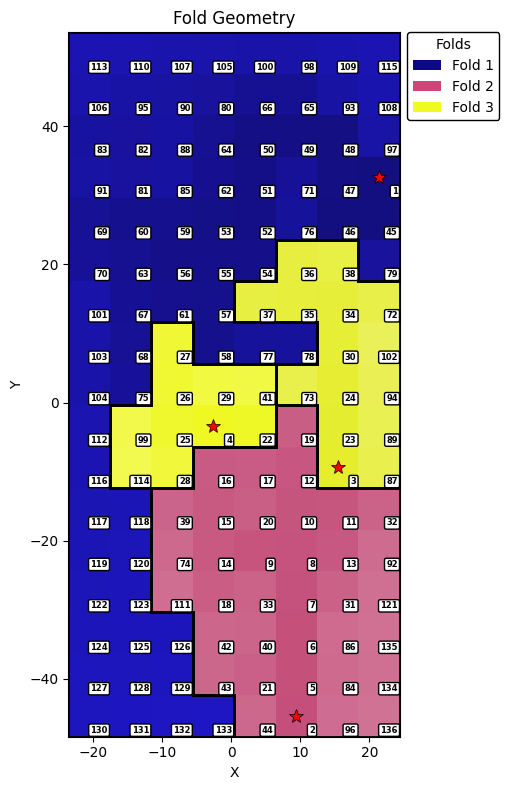

Iteration: 55

Fold Summaries:

Fold 1:
  Intended total counts: 642317.65
  Actual total counts: 488099.0
  Category Counts:
    1_WALL: 244517.0 (50.77% of total 1_WALL)
    2_FLOOR: 76585.0 (54.60% of total 2_FLOOR)
    3_ROOF: 30210.0 (68.65% of total 3_ROOF)
    4_CEILING: 33922.0 (40.54% of total 4_CEILING)
    5_FOOTPATH: 49504.0 (34.12% of total 5_FOOTPATH)
    7_COLUMN: 1423.0 (47.01% of total 7_COLUMN)
    8_DOOR: 15032.0 (70.50% of total 8_DOOR)
    9_WINDOW: 7889.0 (68.01% of total 9_WINDOW)
    10_STAIR: 3555.0 (45.01% of total 10_STAIR)
    11_RAILING: 8815.0 (43.53% of total 11_RAILING)
    12_RWP: 1431.0 (70.63% of total 12_RWP)
    13_OTHER: 15216.0 (55.56% of total 13_OTHER)
  Aspect Ratio: 2.12

Fold 2:
  Intended total counts: 197636.20
  Actual total counts: 265273.0
  Category Counts:
    1_WALL: 118464.0 (24.60% of total 1_WALL)
    2_FLOOR: 34973.0 (24.94% of total 2_FLOOR)
    3_ROOF: 8522.0 (19.37% of total 3_ROOF)
    4_CEILING: 27569.0 (32.95% of total 4_CEI

In [106]:
weights = {1: 0.65, 2: 0.2, 3: 0.15}  # Intended area weights: training, evaluation, test
region_counts = {1: 1, 2: 1, 3: 2}
iterations = 100  # Number of iterations to run
min_percentage_threshold = 5  # Minimum acceptable percentage per category per area

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    region_counts=region_counts,
)

# Run the algorithm
grid_splitter.run()

# Access the best configuration
best_config = grid_splitter.best_configuration

# Plot the result
best_config.plot()

# Print the summary
best_config.print_summary()

In [99]:
# best_config.region_cell_order

In [107]:
# for c in grid_splitter.all_configurations:
#     c.plot()

In [108]:
# # Process the folds and get the rectangles
# fold_rectangles = process_folds(best_config.grid)

In [110]:
# fold_meshes = crop_meshes_per_fold(
#     dh.extracted_meshes,
#     loaded_data['fold_rectangles'],
#     loaded_data['x_edges'],
#     loaded_data['y_edges']
# )

In [109]:
# plot_mesh_folds(fold_meshes)

In [27]:
# fold_name_map = {
#     1: 'train',
#     2: 'test',
#     3: 'eval',
# }

# fold_meshes_2 = {fold_name_map[k]: v for k, v in fold_meshes.items()}

In [111]:
# save_splits(dh, fold_meshes_2)

In [112]:
# dh.generate_and_save_fold_clouds(resolution=0.02, poisson_radius=0.05, save_all_formats=True)